In [1]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
random_seed=42
torch.manual_seed(random_seed)
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score
np.random.seed(random_seed)

import torch
import torch.optim as optim
import torch.nn.functional as F

In [2]:
label_dict={
    "01_TUMOR":0,
    "02_STROMA":1,
    "03_COMPLEX":2,
    "04_LYMPHO":3,
    "05_DEBRIS":4,
    "06_MUCOSA":5,
    "07_ADIPOSE":6,
    "08_EMPTY":7
}
params={
    'batch_size':32,
    'shuffle':True,
    'num_workers':4,
    'pin_memory':True,
    'epochs':20,
    'lr':0.001,
    'device':'cuda' if torch.cuda.is_available() else 'cpu'
    
}
num_classes=10
test_splits=[.95,.9,.8,.75,.7,.65,.6]

In [3]:
def compute_cosine_similarity(grad1, grad2):
    """
    Computes the cosine similarity between two gradient dictionaries.
    
    Args:
        grad1 (dict): Gradient dictionary 1.
        grad2 (dict): Gradient dictionary 2.
    
    Returns:
        float: Cosine similarity score.
    """
    cosine_similarity = 0.0
    num_valid_keys = 0  # To track valid gradient pairs

    for key in grad1.keys():
        g1, g2 = grad1[key], grad2[key]
        
        # Ensure both gradients are valid tensors
        if g1 is not None and g2 is not None and g1.numel() > 0 and g2.numel() > 0:
            dot_product = torch.sum(g1 * g2)
            norm_g1 = torch.norm(g1)
            norm_g2 = torch.norm(g2)

            if norm_g1 > 0 and norm_g2 > 0:  # Avoid division by zero
                cosine_similarity += (dot_product / (norm_g1 * norm_g2)).item()
                num_valid_keys += 1

    # Average cosine similarity over all valid keys
    return cosine_similarity / num_valid_keys if num_valid_keys > 0 else 0.0

In [4]:
class DataMaker:

    def __init__(self,root_path:str,label_dict:dict,test_splits:list[float]):

        self.root_path=root_path
        self.label_dict=label_dict
        self.test_splits=test_splits

        # assert len(os.listdir(self.root_path)==len(label_dict)), "Mismatch between nuber of classes in label dict and number of classes found in root directory ."
        assert sorted(os.listdir(self.root_path))==sorted(list(label_dict.keys())), "Mismatch between nuber of classes in label dict and number of classes found in root directory ."

        self.classImages=self.classes_data()

        self.df=self.classes_df(self.classImages)
        print(self.df.head())

        self.test_train_val_split()
    
    def labelize(self,row):
        
        return self.label_dict[row]

    def classes_data(self):

        classImages={item:[] for item in self.label_dict.keys()}

        for className in os.listdir(self.root_path):
            for imageName in os.listdir(os.path.join(self.root_path,className)):
                classImages[className].append(os.path.join(self.root_path,className,imageName))
            
        return classImages
    

    def classes_df(self,classImages:dict[str,str]):

        print("Creating dataframe....")

        all_files,all_labels=[],[]

        for key in self.classImages:
            len_imagesClass=len(self.classImages[key])
            all_files.extend(self.classImages[key])
            all_labels.extend([key]*len_imagesClass)

        new_df=pd.DataFrame({
            "Filename":all_files,
            "Labels":all_labels
        })
    
        new_df['Labels']=new_df['Labels'].apply(lambda x:self.labelize(x))

  
        return new_df
    
    def test_train_val_split(self):

        for split in test_splits:

            train_df_,test_df_=train_test_split(self.df,test_size=split,random_state=random_seed,shuffle=True)
            test_df_,val_df_=train_test_split(test_df_,test_size=0.2,random_state=random_seed,shuffle=True)
            test_df_.reset_index(drop=True,inplace=True)
            train_df_.reset_index(drop=True,inplace=True)
            val_df_.reset_index(drop=True,inplace=True)
        
            train_df_.to_csv('Training_point{}.csv'.format(int(split*100)),index=False)
            test_df_.to_csv('Test_point{}.csv'.format(int(split*100)),index=False)
            val_df_.to_csv('Val_point{}.csv'.format(int(split*100)),index=False)
    
        print("Data saved successfully!.....")
                



In [5]:
d=DataMaker(root_path='/kaggle/input/kather2016/Kather_texture_2016_image_tiles_5000',label_dict=label_dict,test_splits=[.95,.8,.75,.7,.65,.6])

Creating dataframe....
                                            Filename  Labels
0  /kaggle/input/kather2016/Kather_texture_2016_i...       0
1  /kaggle/input/kather2016/Kather_texture_2016_i...       0
2  /kaggle/input/kather2016/Kather_texture_2016_i...       0
3  /kaggle/input/kather2016/Kather_texture_2016_i...       0
4  /kaggle/input/kather2016/Kather_texture_2016_i...       0
Data saved successfully!.....


In [6]:
#@title "Load train,test,val"
def read_csv(path:str):
  df=pd.read_csv(path)
  return df

train_df=read_csv('Training_point95.csv')
test_df=read_csv('Test_point95.csv')
val_df=read_csv('Val_point95.csv')

print(f''' 
Training data: {train_df.shape[0]}\n
Test data : {test_df.shape[0]}\n
Validation data : {val_df.shape[0]}
''')

 
Training data: 250

Test data : 3800

Validation data : 950



In [7]:
#@title "Custom Dataset Labeled"
class TissueData(Dataset):
  @staticmethod
  def read_img(path:str):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(224,224))
    img=img.astype(np.float32)
    img=np.transpose(img,(2,0,1))
    img=img/255.
    return img
  def __init__(self,df:pd.DataFrame):
    self.df=df
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    img_path=self.df.iloc[idx,0]
    img=self.read_img(img_path)
    label=int(self.df['Labels'][idx])
    return img,label

#@title "Custom Dataset Unlabeled"
class UnlabeledTissueData(Dataset):
  @staticmethod
  def read_img(path:str):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(224,224))
    img=img.astype(np.float32)
    img=np.transpose(img,(2,0,1))
    img=img/255.
    return img
  def __init__(self,df:pd.DataFrame):
    self.df=df
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    img_path=self.df.iloc[idx,0]
    img=self.read_img(img_path)
    return img

In [9]:
labeled_ds=TissueData(train_df)
labeled_loader=DataLoader(labeled_ds,batch_size=params['batch_size'],shuffle=True)
val_ds=TissueData(val_df)
labeled_test_loader=DataLoader(TissueData(test_df),batch_size=params['batch_size'],shuffle=False)

In [10]:
#Remove labels from test_df
unlabelled_df=test_df.drop('Labels',axis=1)
unlabelled_df=unlabelled_df.reset_index(drop=True)
unlabeled_loader=DataLoader(UnlabeledTissueData(unlabelled_df),batch_size=params['batch_size'],shuffle=False)
val_loader=DataLoader(val_ds,batch_size=params['batch_size'],shuffle=False)

In [11]:
import torchvision.models.quantization as models
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1`. You can also use `weights=ResNet18_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth
100%|██████████| 11.2M/11.2M [00:00<00:00, 59.4MB/s]
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:389: UserWarning: TypedStorage is deprecated. It will be removed in the future and Unt

In [18]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.


  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_classes),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )

    
      
  return new_model

In [19]:
student = create_combined_model(model_fe)
student = student.to('cpu')

teacher = create_combined_model(model_fe)
teacher = teacher.to('cpu')

In [20]:
num_epochs=params['epochs']

# Optimizers
t_optimizer = optim.SGD(teacher.parameters(), lr=0.001,momentum=0.9)
s_optimizer = optim.SGD(student.parameters(), lr=0.001,momentum=0.9)

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [21]:
from itertools import cycle
params['device']='cpu'
teacher.to(params['device'])
student.to(params['device'])

from itertools import cycle
for epoch in range(num_epochs):
    
    # Initialize metrics
    epoch_train_loss, epoch_train_correct, total_train_samples = 0.0, 0, 0
    epoch_val_loss, epoch_val_correct, total_val_samples = 0.0, 0, 0

    teacher.train()
    student.train()

    mini_batch_counter = 0
    n_batches = 10

    # Iterate over labeled and unlabeled data
    for (labeled_batch, unlabeled_batch) in zip(labeled_loader, cycle(unlabeled_loader)):
        mini_batch_counter += 1

        # Load labeled data
        l_x, l_y = labeled_batch
        l_x, l_y = l_x.to(params['device']), l_y.to(params['device'])

        # Load unlabeled data
        u_x = unlabeled_batch
        u_x = u_x.to(params['device'])

        # Zero gradients for both optimizers
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()

        # ----------------------------------
        # Pseudo-labeling by Teacher
        # ----------------------------------
        y_u_pred_logits = teacher(u_x)
        y_u_pred = torch.argmax(y_u_pred_logits.detach(), dim=1)

        # ----------------------------------
        # Student trains on pseudo-labeled data
        # ----------------------------------
        s_u_logits = student(u_x)
        s_u_loss = F.cross_entropy(s_u_logits, y_u_pred)
        s_u_loss.backward()

        # Store gradients for unlabeled data
        student_unlabeled_gradients = {
            name: param.grad.clone() if param.grad is not None else None
            for name, param in student.named_parameters()
        }

        s_optimizer.step()

        # ----------------------------------
        # Student trains on labeled data
        # ----------------------------------
        s_optimizer.zero_grad()
        s_l_logits = student(l_x)
        s_l_loss = F.cross_entropy(s_l_logits, l_y)
        s_l_loss.backward()

        # Store gradients for labeled data
        student_labeled_gradients = {
            name: param.grad.clone() if param.grad is not None else None
            for name, param in student.named_parameters()
        }

        s_optimizer.zero_grad()

        # Compute cosine similarity
        h = compute_cosine_similarity(student_labeled_gradients, student_unlabeled_gradients)

        # ----------------------------------
        # Teacher meta-loss (MPL)
        # ----------------------------------
        t_l_logits = teacher(l_x)
        t_l_loss = F.cross_entropy(t_l_logits, l_y)
        t_mpl_loss = h * F.cross_entropy(y_u_pred_logits, y_u_pred)

        (t_l_loss + t_mpl_loss).backward()
        t_optimizer.step()

        # Track training metrics
        batch_train_loss = s_l_loss.item()
        batch_train_accuracy = (torch.argmax(s_l_logits, dim=1) == l_y).float().mean().item()

        epoch_train_loss += batch_train_loss * l_x.size(0)
        epoch_train_correct += (torch.argmax(s_l_logits, dim=1) == l_y).sum().item()
        total_train_samples += l_x.size(0)

        # Print metrics every `n_batches`
        if mini_batch_counter % n_batches == 0:
            avg_batch_train_loss = epoch_train_loss / total_train_samples
            avg_batch_train_accuracy = epoch_train_correct / total_train_samples

            print(f'[Epoch {epoch+1}, Batch {mini_batch_counter}] '
                  f'Batch Loss: {avg_batch_train_loss:.4f}, Batch Accuracy: {avg_batch_train_accuracy:.4f}')

    # ----------------------------------
    # Validation after each epoch
    # ----------------------------------
    # teacher.eval()
    # student.eval()
    # with torch.no_grad():
    #     for val_batch in val_loader:
    #         val_x, val_y = val_batch
    #         val_x, val_y = val_x.to(params['device']), val_y.to(params['device'])

    #         val_logits = student(val_x)
    #         val_loss = F.cross_entropy(val_logits, val_y)

    #         epoch_val_loss += val_loss.item() * val_x.size(0)
    #         epoch_val_correct += (torch.argmax(val_logits, dim=1) == val_y).sum().item()
    #         total_val_samples += val_x.size(0)

    # Average losses and accuracies
    avg_train_loss = epoch_train_loss / total_train_samples
    avg_train_accuracy = epoch_train_correct / total_train_samples
    
    # avg_val_loss = epoch_val_loss / total_val_samples
    # avg_val_accuracy = epoch_val_correct / total_val_samples

    # Append metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    
    # val_losses.append(avg_val_loss)
    # val_accuracies.append(avg_val_accuracy)

    # Print epoch summary
    print (f'End of Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}'
          )
          # f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')


End of Epoch 1/20, Train Loss: 2.4441, Train Accuracy: 0.0600
End of Epoch 2/20, Train Loss: 2.5600, Train Accuracy: 0.0440
End of Epoch 3/20, Train Loss: 2.6020, Train Accuracy: 0.1480
End of Epoch 4/20, Train Loss: 2.7066, Train Accuracy: 0.1600
End of Epoch 5/20, Train Loss: 2.4823, Train Accuracy: 0.2040
End of Epoch 6/20, Train Loss: 2.3544, Train Accuracy: 0.3720
End of Epoch 7/20, Train Loss: 2.2334, Train Accuracy: 0.3800
End of Epoch 8/20, Train Loss: 2.0247, Train Accuracy: 0.4120
End of Epoch 9/20, Train Loss: 1.7848, Train Accuracy: 0.4560
End of Epoch 10/20, Train Loss: 1.7095, Train Accuracy: 0.4400
End of Epoch 11/20, Train Loss: 1.6444, Train Accuracy: 0.4960
End of Epoch 12/20, Train Loss: 1.5100, Train Accuracy: 0.5160
End of Epoch 13/20, Train Loss: 1.4387, Train Accuracy: 0.5280
End of Epoch 14/20, Train Loss: 1.3674, Train Accuracy: 0.5320
End of Epoch 15/20, Train Loss: 1.3765, Train Accuracy: 0.4840
End of Epoch 16/20, Train Loss: 1.3251, Train Accuracy: 0.5680
E

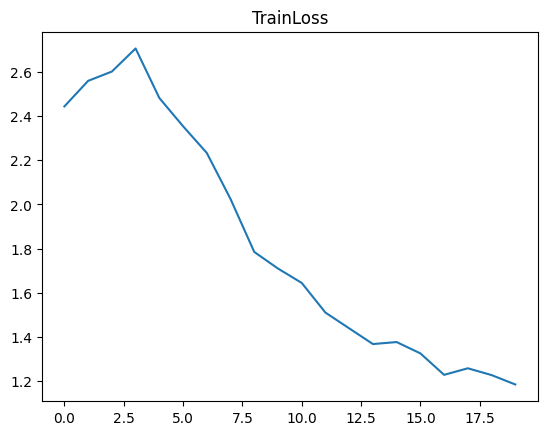

In [22]:
import matplotlib.pyplot as plt
plt.title("TrainLoss")
plt.plot(train_losses)

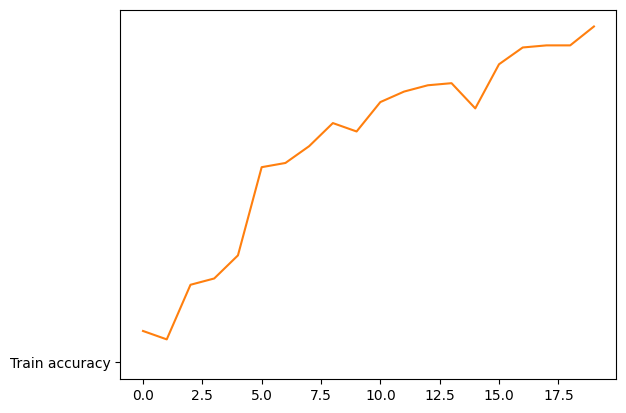

In [23]:
plt.plot("Train accuracy")
plt.plot(train_accuracies)

Validation Accuracy : 64.10984848484848


F1 Score: 0.6103467358961674




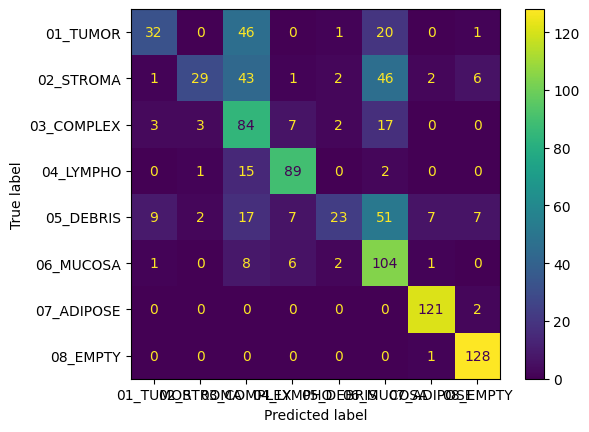

In [33]:
from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay

def evaluate(model,loader):
    model.eval()
    device='cpu'
    acc=[]
    preds=[]
    labels=[]
    with torch.no_grad():
        for idx,item in enumerate(loader):
            img,label=item
            img=img.to(device)
            label=label.to(device)
            out=model(img)
            out=torch.argmax(out,dim=1)
            acc.append((out==label).sum().item()*100/img.size(0))
            preds.extend(out.cpu().numpy())
            labels.extend(label)

    print("Validation Accuracy : {}\n\n".format(np.average(np.array(acc))))

    f1_score_preds=f1_score(labels,preds,average='macro')

    print("F1 Score: {}\n\n".format(f1_score_preds))
    
    cm=confusion_matrix(labels,preds)
    disp=ConfusionMatrixDisplay(cm,display_labels=list(label_dict.keys()))
    disp.plot()

    return f1_score_preds
    

f1_score_preds=evaluate(student,val_loader)

In [34]:
def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(student)

Size (MB): 11.320618


In [37]:
model_fe_new = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model_fe_new.fc.in_features
model_fe_new.fc=nn.Linear(
    num_ftrs,num_classes
)

In [39]:
print_size_of_model(model_fe_new)

Size (MB): 44.7977
